In [26]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
words = open('karpathy/makemore/names.txt', 'r').read().splitlines()

In [30]:
#build the vocabulary of hcaracters and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

27


In [32]:
block_size = 3
def build_dataset(words):
    X,Y = [],[]
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  #crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
            
Xtr, Ytr = build_dataset(words[:n1])    
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [34]:
#let's train a deeper network
#模仿pytorch的方法构建模型：
class linear:
    def __init__(self,fan_in,fan_out,bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self,dim,eps = 1e-5,momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
#self.training 控制着 BatchNorm1d 层的工作模式。当 self.training 为 True 时，表示处于训练模式，
#会根据当前输入 x 计算均值和方差，并更新 running_mean 和 running_var。
#而当 self.training 为 False 时，表示处于推理或测试模式，使用之前计算好的 running_mean 和 running_var 来进行标准化。
        #parameters
        self.gamma = torch.zeros(dim)
        self.beta = torch.ones(dim)
        #buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self,x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0,keepdim = True)
            xvar = x.var(0,keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
#xhat 是标准化后的输入数据，通过将 x 减去均值 xmean 并除以标准差的平方根（加上一个很小的值 eps 防止除以零）得到。
        self.out = self.gamma *xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1- self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
#新增操作：代替原来的emb = C[X]
class Embedding:
    def __init__(self,num_embeddings,embedding_dim):
        self.weight = torch,randn((num_embeddings,embedding_dim))
    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]
#新增操作代替原来的x = emb.view(emb.shape[0],-1)
class Flatten:
    def __call__(self,x):
        self.out = x.view(x.shape[0],-1)
        return self.out
    def parameters(self):
        return []

n_embd = 10
n_hidden =200 # the number of neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd))
layers = [  #使用六层多层感知机
    Embedding(vocab_size,n_embd),
    Flatten(),
    linear(n_embd * block_size, n_hidden, bias = False),BatchNorm1d(n_hidden), Tanh(),
    linear(n_hidden, vocab_size)
]  #如果线性层之间不用tanh()层连接的话，那么许多线性层叠加之后就会产生一个线性层的效果

with torch.no_grad():  #这段代码的含义见下图
    #last layer: make less confident
    layers[-1].weight *=0.1
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True    

12097


In [36]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []
stepi = []
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
        lossi.append(loss.log10().item())
        stepi.append(i)
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log().item() for p in parameters])

      0/ 200000:3.2742
  10000/ 200000:2.2367
  20000/ 200000:2.1368
  30000/ 200000:2.1694
  40000/ 200000:2.2415
  50000/ 200000:2.0394
  60000/ 200000:2.7240
  70000/ 200000:2.3194
  80000/ 200000:2.3140
  90000/ 200000:2.0710
 100000/ 200000:2.2668
 110000/ 200000:2.3410
 120000/ 200000:1.9761
 130000/ 200000:2.0599
 140000/ 200000:2.4630
 150000/ 200000:1.9083
 160000/ 200000:2.0631
 170000/ 200000:1.9033
 180000/ 200000:2.4144
 190000/ 200000:2.2185


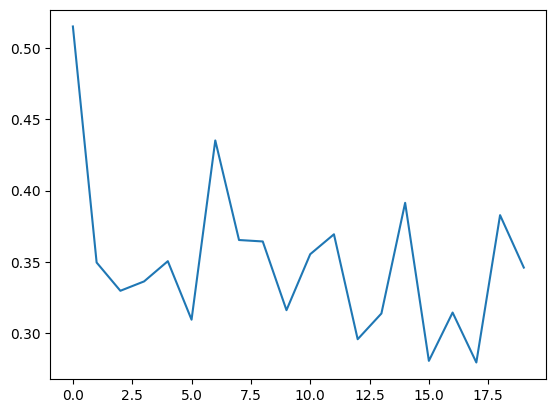

In [38]:
plt.plot(lossi)

In [40]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

RuntimeError: shape '[-1, 1000]' is invalid for input of size 20

In [ ]:
for layer in layers:
    layer.training = False

In [ ]:
@torch.no_grad()  #让下面这个函数执行的所有变量都无grad也就是no_grad,从而不能进行反向传播
#adecorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)  #loss function
    print(split,loss.item())
split_loss('train')
split_loss('val')

In [ ]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1)  #，view(1, -1)是将emb的维度调整为1行，剩下的维度自动计算得出。
        logits = h @ W2 + b2 #最终输出 logits
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(p, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))